# Figure 1 - teleconnections and corresponding economic effects
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

Data locations

In [2]:
loc_coefs = "../Data/RegressionResults/"
loc_panel = "../Data/Panel/"
loc_shp = "../Data/ProcessedCountryShapefile/"

Panel info

In [3]:
y1 = 1960
y2 = 2019

Shapefile

In [4]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

#### Analysis

Read coefs

In [5]:
phase = "ENSO"
enso_var = "e_e-and-c"
response = "gr_pwt_frac" #"gr_deviation" 
trend = "none"
nlag = 5
lags = np.arange(0,nlag+1,1)
tc_metric = "t_p_corr_running_e"

In [6]:
enso_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interacted_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
int_coefs = pd.read_csv(loc_coefs+phase+"_teleconnection-interaction_coefs_bootstrap-dist_lag"+str(nlag)+"_"+enso_var+"_"+response+"_trend"+trend+".csv",index_col=0)
nboot = len(int_coefs.coef_lag0.values)

Read panel for info like distribution of teleconnection strengths

In [7]:
panel = pd.read_csv(loc_panel+"ENSO_Growth_Panel_"+str(y1)+"-"+str(y2)+".csv",index_col=0)
panel_corrs = np.unique(panel[tc_metric].values)

In [8]:
e = panel.loc[panel.iso=="USA","e"].values

In [9]:
np.std(e[e>0])

1.0432697800526303

In [10]:
np.std(e[e<0])

0.34559696158193887

(array([31., 42., 29., 16., 22., 12.,  2.,  0.,  1.,  1.]),
 array([0.2852641 , 0.39456051, 0.50385693, 0.61315334, 0.72244975,
        0.83174616, 0.94104257, 1.05033899, 1.1596354 , 1.26893181,
        1.37822822]),
 <a list of 10 Patch objects>)

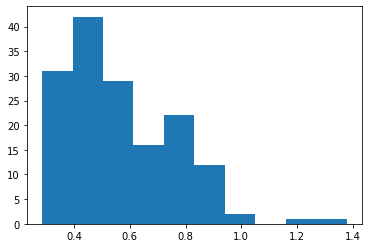

In [11]:
plt.hist(panel_corrs)

In [12]:
print(np.nanmin(panel_corrs))
print(np.nanmax(panel_corrs))

0.2852641025023439
1.3782282224881373


Create marginal effects

In [13]:
corrs = np.arange(0.25,1.4+0.01,0.01)

In [14]:
corr_means = np.zeros((len(corrs),nlag+1))
corr_upper = np.zeros((len(corrs),nlag+1))
corr_lower = np.zeros((len(corrs),nlag+1))

In [15]:
for c in corrs:
    corr_indiv = np.zeros((nboot,nlag+1))
    for l in np.arange(0,nlag+1,1):
        enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
        int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
        me = enso_coef + (int_coef * c)
        #me = int_coef*c
        corr_indiv[:,l] = me
        
    cumulative = np.cumsum(corr_indiv,axis=1)
    corr_means[list(corrs).index(c),:] = np.mean(cumulative,axis=0)
    corr_upper[list(corrs).index(c),:] = np.percentile(cumulative,97.5,axis=0)
    corr_lower[list(corrs).index(c),:] = np.percentile(cumulative,2.5,axis=0)

Plot!

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/dartf

[-1.02012349 -1.57407315 -2.66834226 -3.60302019 -4.35447051 -4.96040048]
[-1.33046619 -2.05858467 -3.5161306  -4.69933805 -5.7302633  -6.48641925]
[-0.75005274 -1.16955436 -2.01531764 -2.73068944 -3.25711535 -3.73603917]


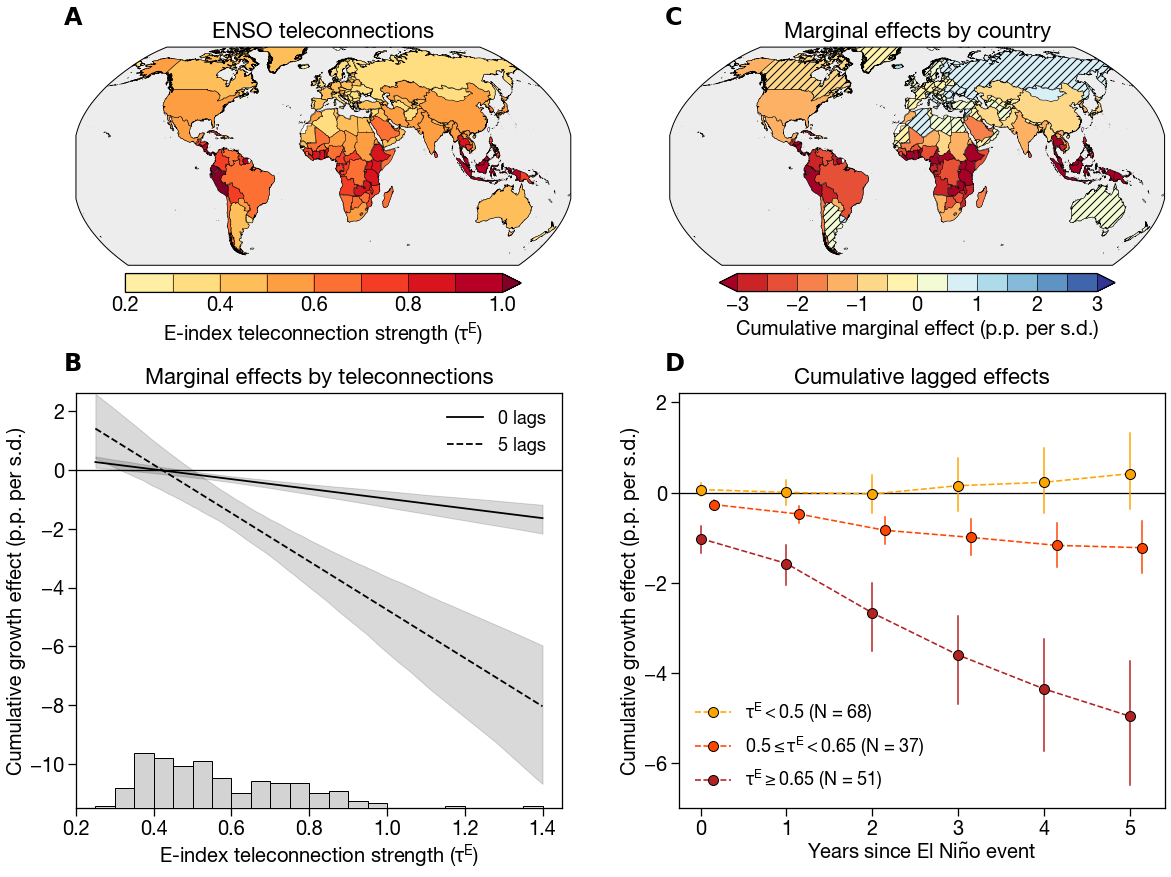

In [16]:
fig = plt.figure(figsize=(18,16))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

jitter = 0.15
tfs = 22

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.1,right=0.94,top=0.9,bottom=0.54,wspace=0.2,hspace=0.23)

## teleconnections map
ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

cmin = 0.2
cmax = 1.0
nrange = 9
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
corr_cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

for i in np.unique(panel.iso.values):
    if i in iso_shp:
        val = np.nanmean(panel.loc[panel.iso==i,tc_metric])
        if ~np.isnan(val):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=corr_cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)

plt.title("ENSO teleconnections",pad=10,fontsize=tfs)

#cbar_ax = fig.add_axes([0.15,0.57,0.305,0.02])
cb = fig.colorbar(corr_cbar,orientation="horizontal",
                      drawedges=True,extend="max",
                 shrink=0.8,aspect=20,pad=0.02,
                 ticks=[0.2,0.4,0.6,0.8,1.0])
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("E-index teleconnection strength ("+r"$\tau^E$)",
             rotation=0,labelpad=5)




## marginal effects map
ax = plt.subplot(gs1[0,1],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

cmin = -3
cmax = 3
nrange = 13
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('RdYlBu')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

country_effects = xr.DataArray(np.full(len(np.unique(panel.iso.values)),np.nan),
                               coords=[np.unique(panel.iso.values)],dims=["iso"])
country_sig = xr.DataArray(np.full(len(np.unique(panel.iso.values)),np.nan),
                               coords=[np.unique(panel.iso.values)],dims=["iso"])
for i in np.unique(panel.iso.values):
    if i in iso_shp:
        c = np.nanmean(panel.loc[panel.iso==i,tc_metric])
        corr_indiv = np.zeros((nboot,nlag+1))
        for l in np.arange(0,nlag+1,1):
            enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
            int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
            me = enso_coef + (int_coef * c)
            #me = int_coef*c
            corr_indiv[:,l] = me
        cumulative = np.cumsum(corr_indiv,axis=1)        
        val = np.mean(cumulative,axis=0)[-1]*100
        upper = np.percentile(cumulative,97.5,axis=0)[-1]*100
        lower = np.percentile(cumulative,2.5,axis=0)[-1]*100
        if (upper>0)&(lower<0):
            sig=0
        else:
            sig=1
        country_effects.loc[i] = val
        country_sig.loc[i] = sig
        if ((~np.isnan(val)) & (sig==1)):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        elif ((~np.isnan(val)) & (sig==0)):
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5,
                             hatch="///")
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        
plt.title("Marginal effects by country",pad=10,fontsize=tfs)

# colorbar
#cbar_ax = fig.add_axes([0.59,0.57,0.305,0.02])
cb = fig.colorbar(cbar,orientation="horizontal",
                      drawedges=True,extend="both",
                 shrink=0.8,aspect=20,pad=0.02,
                 ticks=[-3,-2,-1,0,1,2,3])
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("Cumulative marginal effect (p.p. per s.d.)",
             rotation=0,labelpad=5)



### now marginal effects by teleconnection


gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.1,right=0.94,top=0.49,bottom=0.13,wspace=0.24,hspace=0.23)

ax = plt.subplot(gs2[0,0])
#ax.spines["right"].set_visible(False)
#ax.spines["top"].set_visible(False)

# cols
lag1_col = "black" #np.array([34,136,51])/255.
lag5_col = "black" #np.array([68,119,170])/255.
lag1_lt = "-"
lag2_lt = "--"
alph = 0.15

# lag0
mn = corr_means[:,0]*100
upper = corr_upper[:,0]*100
lower = corr_lower[:,0]*100
plt.plot(corrs,mn,color=lag1_col,linewidth=1.8,label="0 lags",
        zorder=2,linestyle=lag1_lt)
ax.fill_between(corrs,lower,upper,
                color=lag1_col,
                alpha=alph,zorder=2)

# lag5
mn = corr_means[:,-1]*100
upper = corr_upper[:,-1]*100
lower = corr_lower[:,-1]*100
plt.plot(corrs,mn,color=lag5_col,linewidth=1.8,label="5 lags",
        zorder=1,linestyle=lag2_lt)
ax.fill_between(corrs,lower,upper,
                color=lag5_col,
                alpha=alph,zorder=1)

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-")

plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.xlabel("E-index teleconnection strength ("+r"$\tau^E$)")

plt.ylim([-11.5,2.6])
#plt.yticks([-6,-5,-4,-3,-2,-1,0,1,2])
plt.yticks(np.arange(-10,2+1,2))
xl = [0.2,1.45]
plt.xlim(xl)
#plt.xticks([0.2,0.4,0.6,0.8,1.0,1.2,1.4])
plt.title("Marginal effects by teleconnections",pad=10,fontsize=tfs)
plt.legend(loc="upper right",frameon=False,fontsize=18,ncol=1)


inset_ax = fig.add_axes([0.1,0.13,0.375,0.08])

bns = np.arange(0.2,1.45+0.05,0.05)
inset_ax.hist(np.unique(panel_corrs),color="lightgray",
              linewidth=1,edgecolor="black",bins=bns)

inset_ax.spines["right"].set_visible(False)
inset_ax.spines["top"].set_visible(False)
inset_ax.set_xlim(xl)
inset_ax.set_ylim([0,37])
inset_ax.spines["bottom"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.set_yticks([])
inset_ax.set_xticks([])
inset_ax.patch.set_alpha(0)


## cumulative lags
ax = plt.subplot(gs2[0,1])
#ax.spines["right"].set_visible(False)
#ax.spines["top"].set_visible(False)

# loop through a set of bins and plot
bds_min = [0,0.5,0.65]
bds_max = [0.5,0.65,1.7]
ns = np.zeros(len(bds_min))
mns = np.zeros(len(bds_min))
for b in np.arange(0,len(bds_min),1):
    panel_corrs_uq = np.unique(panel_corrs)
    corrs_for_n = panel_corrs_uq[(~np.isnan(panel_corrs_uq))&(panel_corrs_uq>0.0)]
    ns[b] = int(len(corrs_for_n[[(x>=bds_min[b])&(x<bds_max[b]) for x in corrs_for_n]]))
    mns[b] = np.mean(corrs_for_n[[(x>=bds_min[b])&(x<bds_max[b]) for x in corrs_for_n]])
    
lbs = [r"$\tau^E<$"+str(bds_max[0])+" (N = "+str(int(ns[0]))+")",\
       str(bds_min[1])+r"$\leq\tau^E<$"+str(bds_max[1])+" (N = "+str(int(ns[1]))+")",\
       r"$\tau^E\geq$"+str(bds_min[2])+" (N = "+str(int(ns[2]))+")"]
bin_cols = ["orange","orangered","firebrick"]

for b in np.arange(0,len(bds_min),1):
    mn_corr = bds_min[b]
    mx_corr = bds_max[b]
    lb = lbs[b]
    nlags = np.arange(0,nlag+1,1)
    
    corr_inds = [(x>=mn_corr)&(x<mx_corr) for x in corrs]
    me_mean = np.mean(corr_means[corr_inds,:],axis=0)*100
    me_upper = np.mean(corr_upper[corr_inds,:],axis=0)*100
    me_lower = np.mean(corr_lower[corr_inds,:],axis=0)*100
    if b==(len(bds_min)-1):
        print(me_mean)
        print(me_lower)
        print(me_upper)
    #col = corr_cbar.to_rgba(mns[b])
    col = bin_cols[b]
    if b == 1:
        jt = 0.15
    else:
        jt = 0
    plt.plot(lags+jt,me_mean,color=col,markersize=10,
            zorder=3,marker="o",linestyle="--",
            label=lb,linewidth=1.6,
            markerfacecolor=col,markeredgecolor="black")
    
    for l in np.arange(0,nlag+1,1):
        plt.plot([l+jt,l+jt],[me_lower[l],me_upper[l]],
                color=col,linewidth=1.5,linestyle="-",zorder=2)

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="-",zorder=1)
plt.ylim([-7,2.2])
plt.yticks([-6,-4,-2,0,2])
plt.xticks([0,1,2,3,4,5])
leg = plt.legend(loc="lower left",frameon=False,fontsize=18)
#title="Teleconnection strength"
leg._legend_box.align = "left"
#leg.get_title().set_fontsize('18')
plt.ylabel("Cumulative growth effect (p.p. per s.d.)")
plt.xlabel("Years since El Ni${\~n}$o event")
plt.title("Cumulative lagged effects",pad=10,fontsize=tfs)


# panels
plt.figtext(0.09,0.81,r'$\bf{A}$',fontsize=24)
plt.figtext(0.554,0.81,r'$\bf{C}$',fontsize=24)
plt.figtext(0.09,0.51,r'$\bf{B}$',fontsize=24)
plt.figtext(0.554,0.51,r'$\bf{D}$',fontsize=24)


plt.savefig("../Figures/Fig1.pdf")

plt.show()

In [17]:
panel.loc[panel.iso=="USA",tc_metric].values[0]

0.5529114711209926

In [18]:
panel.loc[panel.iso=="AUS",tc_metric].values[0]

0.4180423525598196

In [19]:
panel.loc[panel.iso=="CHL",tc_metric].values[0]

0.6218623064006106

In [20]:
panel.loc[panel.iso=="PER",tc_metric].values[0]

1.177166592580112

In [21]:
panel.loc[panel.iso=="ECU",tc_metric].values[0]

1.3782282224881373

In [22]:
c = np.around(panel.loc[panel.iso=="PER",tc_metric].values[0],2)
print(c)
corr_indiv = np.zeros((nboot,nlag+1))
for l in np.arange(0,nlag+1,1):
    enso_coef = enso_coefs.loc[:,"coef_lag"+str(l)].values
    int_coef = int_coefs.loc[:,"coef_lag"+str(l)].values
    me = enso_coef + (int_coef * c)
    corr_indiv[:,l] = me
        
cumulative = np.cumsum(corr_indiv,axis=1)
me_mean = np.mean(cumulative,axis=0)
me_upper = np.percentile(cumulative,97.5,axis=0)
me_lower = np.percentile(cumulative,2.5,axis=0)

1.18


In [23]:
me_mean*100

array([-1.27716653, -1.94746743, -3.29188933, -4.49165589, -5.43870169,
       -6.23321432])

In [25]:
me_upper*100

array([-0.93550667, -1.44495182, -2.47271273, -3.3808901 , -4.05706604,
       -4.69492872])

In [26]:
me_lower*100

array([-1.67336334, -2.56349273, -4.3803546 , -5.90871579, -7.23017929,
       -8.19713878])

In [27]:
country_effects_1 = country_effects[(~np.isnan(country_effects))&(~np.isnan(country_sig))]
country_sig_1 = country_sig[(~np.isnan(country_effects))&(~np.isnan(country_sig))]

In [28]:
len(country_effects_1[(country_sig_1==1)&(country_effects_1<0)])/len(country_effects_1)

0.5641025641025641

In [29]:
country_effects_1[(country_effects_1>0)&(country_sig_1==1)]

<xarray.DataArray (iso: 3)>
array([0.90945658, 1.1140904 , 0.90710309])
Coordinates:
  * iso      (iso) object 'BGR' 'ISL' 'MNG'

In [30]:
np.nanmean(country_effects_1[(country_sig_1==1)&(country_effects_1<0)])

-2.251846257806788

Effects for tau > 0.5?

In [31]:
country_tau = np.array([panel.loc[panel.iso==x,tc_metric].values[0] for x in country_effects_1.iso.values])

In [32]:
np.nanmean(country_effects_1[country_tau>0.5])

-2.251846257806788